In [1]:
import matplotlib.pyplot as plt
from importlib import reload
import cchdo_tools
import numpy as np

reload(cchdo_tools)

<module 'cchdo_tools' from '/HOME/ras/python/cchdo_toolkit/cchdo_tools.py'>

# CCHDO_toolkit description
Much of the biogeochemical data of the ocean has been collected from bottle data from hydrographic surveys of the ocean. While some of these variables exist as gridded data, they are susceptible to gridding errors. As such the original data along transects remain some of the best 'ground truth'. The cchdo_toolkit contains a number of routines that extract the bottle data downloaded from the CCHDO database https://cchdo.ucsd.edu/ and objectively map desired quantities which is then suitable for plotting.
## Step 1: Extracting data
The extract_all_expos searches the given datapath and extracts all the requested fields from fields_in. It returns a dictionary containing both station data and bottle data. A number of auxiliary fields are also calcualted at this time including in-situ density, $\sigma_2$, $\sigma_0$, conservative temperature, and absolute salinity. The below call extracts CFC-11, CFC-12, and oxygen data

In [2]:
datapath = '/HOME/ras/datasets/cchdo/subset/'
cruises = cchdo_tools.extract_all_expos(datapath = datapath, fields_in = ['freon_11','freon_12','bottle_oxygen'])

/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:167: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]
/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:163: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]


## Step 2: Mapping the data
At this point, the data are still "scattered" data, so we use an objective mapping routine to smooth the data and map onto isopycnals. Mapping onto isopycnals is preferable to pressure or depth space because it is less susceptible to changes in stratification. Note that this is the part of the package that takes the longest.

In [3]:
name = '33RR20090320'
remap = cchdo_tools.grid_transect_variables(cruises[name]['bottle'], ['pressure','temperature','freon_12','bottle_oxygen'],
                                            xvar='distance',
                                            yvar='sigma2',xcorr=5e5,ycorr=0.2,nx=100,ny=40,npass=2)



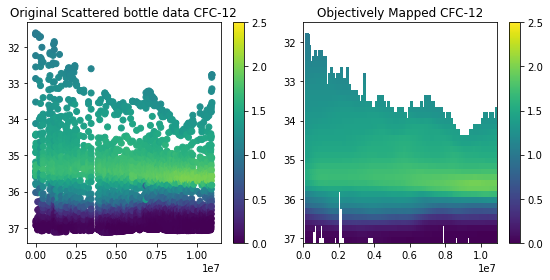

In [4]:
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
plt.scatter(cruises[name]['bottle']['distance'],cruises[name]['bottle']['sigma2'], c =cruises[name]['bottle']['freon_12'],vmin=0,vmax=2.5)
plt.title('Original Scattered bottle data CFC-12')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(remap['distance'],remap['sigma2'],remap['freon_12'],vmin=0,vmax=2.5)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Objectively Mapped CFC-12')
plt.tight_layout()

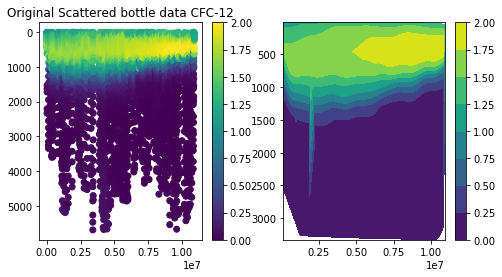

In [60]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.scatter(cruises[name]['bottle']['distance'],cruises[name]['bottle']['pressure'],
            c =cruises[name]['bottle']['freon_12'],vmin=0,vmax=2)
plt.title('Original Scattered bottle data CFC-12')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)

x = remap['distance'].flatten()
y = remap['pressure'].flatten()
z = remap['freon_12'].flatten()

notnan = np.logical_not(np.isnan(z))
x = x[notnan]
y = y[notnan]
z = z[notnan]

plt.tricontourf(x,y,z)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

### Step 3: Comparison with a gridded data
The last step is to sample a gridded data product (e.g. from GLODAP or output from a GCM) using the same sampling pattern as the hydrographic transect.

In [20]:
from netCDF4 import Dataset
nemofile = '/HOME/ras/model_output/cccma/pib-003/PIB-003_1m_10740101_10741231_grid_T.nc'
fields = ['votemper','vosaline','cfc12','nav_lon','nav_lat','deptht']
model = {}
for field in fields:
  model[field] = Dataset(nemofile).variables[field][:]
Dataset(nemofile).close()
  

In [21]:
fields_to_remap = ['votemper','vosaline','cfc12'];
model_sample = cchdo_tools.map_gridded_fields_to_expo(cruises[name]['station'],model,fields_to_remap,tidx=5)

Gridding votemper with shape (46, 292, 362)
Gridding vosaline with shape (46, 292, 362)
Gridding cfc12 with shape (46, 292, 362)


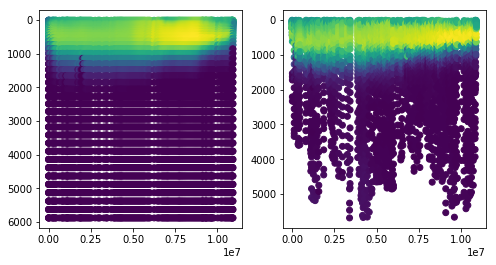

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(model_sample['distance'],model_sample['pressure'], c = model_sample['cfc12'])
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.scatter(cruises[name]['bottle']['distance'],cruises[name]['bottle']['pressure'],c=cruises[name]['bottle']['freon_12'])
plt.gca().invert_yaxis()

Now we that we have similar data sampling, we again use objective mapping to map the model onto the same density space of the observation and compare directly

In [49]:
import gsw
from scipy.interpolate import griddata

model_sample['sigma2'] = gsw.density.sigma2(model_sample['vosaline'],model_sample['votemper'])
model_remap = {}

for field in fields_to_remap:
  model_remap[field] = griddata( 
    (model_sample['distance'].flatten(),model_sample['pressure'].flatten()), model_sample[field].flatten(),
    (remap['distance'],remap['pressure'])
  )
  

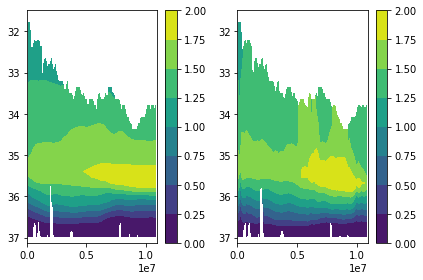

In [53]:
plt.subplot(1,2,1)
plt.contourf(remap['distance'], remap['sigma2'], remap['freon_12'])
plt.gca().invert_yaxis()
ylim = plt.gca().get_ylim()
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(remap['distance'], remap['sigma2'], model_remap['cfc12']*1e9*1.035,vmin=0,vmax=2.)
plt.colorbar()
plt.ylim(ylim)

plt.tight_layout()

ValueError: x and y must be the same size

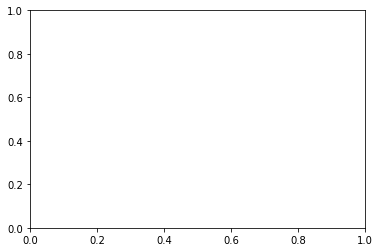

In [46]:
plt.scatter(model_sample['cfc12'].flatten(),remap['freon_12'].flatten())

In [ ]:
model_sm